In [215]:
!cp ~/Downloads/lossrate_*.csv ./

In [216]:
!ls

loss_arrival.csv           ltv_tf_version_2.ipynb
lossrate_daily.csv         ltv_train.csv
lossrate_disbursement.csv  ltv_train_64.csv
lossrate_history.csv       new_ltv_training.csv
lr_time_series_model.ipynb optuna.db
lr_ts_xgb_version.ipynb    taxi-train.csv
ltv_predict.csv            taxi-valid.csv
ltv_tf_version.ipynb       taxifare.ipynb


In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xgb

In [6]:
loss_daily = pd.read_csv("lossrate_daily.csv")

In [7]:
loss_daily.columns

Index(['DISBURSEMENT_DS', 'TOTAL_RECEIVABLES', 'TOTAL_DISBURSEMENT_AMOUNT',
       'TOTAL_PLEDGED_REVENUE', 'D_0_LOSS_RATE', 'D_1_LOSS_RATE',
       'D_2_LOSS_RATE', 'D_3_LOSS_RATE', 'D_4_LOSS_RATE', 'D_5_LOSS_RATE',
       ...
       'D_353_LOSS_RATE', 'D_354_LOSS_RATE', 'D_355_LOSS_RATE',
       'D_356_LOSS_RATE', 'D_357_LOSS_RATE', 'D_358_LOSS_RATE',
       'D_359_LOSS_RATE', 'D_360_LOSS_RATE', 'D_361_LOSS_RATE', 'DIFF'],
      dtype='object', length=367)

In [217]:
loss_history = pd.read_csv("lossrate_history.csv")

In [218]:
loss_dis = pd.read_csv("lossrate_disbursement.csv")

In [13]:
df_daily = loss_daily.sort_values(by=['DISBURSEMENT_DS'])

In [227]:
def extract_time(df_raw, time_feature, col_feature, h=14):
    df = df_raw.sort_values(by=['DISBURSEMENT_DS'])
    length = df.shape[0]
    date_num = np.array(df[time_feature][h:length])
    y = np.array(df[col_feature][h:length])
    x = np.array([df[col_feature][i-14:i][::-1] for i in range(h, length)])
    colname = ['pass_day_col' + str(i) for i in range(0, h)]
    df_g = pd.DataFrame(date_num, columns=['DISBURSEMENT_DS'])
    df_g['y'] = y
    df_g[colname] = x
    return df_g

In [228]:
df_daily = extract_time(loss_daily, 'DISBURSEMENT_DS', 'D_0_LOSS_RATE', h=14)

In [147]:
def bucket(item):
    if int(item) <= 10:
        r_str = str(item)
    elif int(item) <= 50:
        r_str = '10-50'
    elif int(item) <= 100:
        r_str = '50-100'
    elif int(item) <= 200:
        r_str = '100-200'
    elif int(item) <= 300:
        r_str = '200-300'
    else:
        r_str =  'over 350'
    return r_str

In [219]:
loss_history['bucket'] = loss_history['ROWNUMBER'].apply(lambda x: bucket(x))

In [220]:
df_his = pd.pivot_table(loss_history, 
    index='DISBURSEMENT_DS', columns='bucket', values='COUNT_HISTORY', aggfunc='sum')

In [221]:
df_his.shape

(2627, 15)

In [222]:
df_disburse = pd.pivot_table(loss_dis, index='DISBURSEMENT_DS', columns='AMOUNT_BUCKET', values='COUNT_AMOUNT', aggfunc='sum')

In [223]:
df_disburse.fillna(0, inplace=True)

In [165]:
def create_rate_df(df):
    df.fillna(0, inplace=True)
    cols = []
    df['total'] = df.sum(axis=1)
    for item in df.columns:
        if item != 'total':
            df[item + '_rate'] = df[item]/df['total']
            cols.append(item + '_rate')
    return df.loc[:, cols].reset_index()
  
    

In [224]:
df_hist_update = create_rate_df(df_his)

In [225]:
df_disburse_update = create_rate_df(df_disburse)

In [226]:
df_daily.columns

Index(['date', 'y', 'pass_day_col0', 'pass_day_col1', 'pass_day_col2',
       'pass_day_col3', 'pass_day_col4', 'pass_day_col5', 'pass_day_col6',
       'pass_day_col7', 'pass_day_col8', 'pass_day_col9', 'pass_day_col10',
       'pass_day_col11', 'pass_day_col12', 'pass_day_col13'],
      dtype='object')

In [229]:
df_combine1 = pd.merge(df_daily, df_hist_update, on='DISBURSEMENT_DS', how='inner')

In [230]:
df_combine2 = pd.merge(df_combine1, df_disburse_update, on='DISBURSEMENT_DS', how='inner')

In [231]:
df_combine2.shape

(1245, 37)

In [232]:
df_combine2.columns

Index(['DISBURSEMENT_DS', 'y', 'pass_day_col0', 'pass_day_col1',
       'pass_day_col2', 'pass_day_col3', 'pass_day_col4', 'pass_day_col5',
       'pass_day_col6', 'pass_day_col7', 'pass_day_col8', 'pass_day_col9',
       'pass_day_col10', 'pass_day_col11', 'pass_day_col12', 'pass_day_col13',
       '1_rate', '10_rate', '10-50_rate', '100-200_rate', '2_rate',
       '200-300_rate', '3_rate', '4_rate', '5_rate', '50-100_rate', '6_rate',
       '7_rate', '8_rate', '9_rate', 'over 350_rate', '0-100-dollar_rate',
       '100-200-dollar_rate', '200-300-dollar_rate', '300-400-dollar_rate',
       '400-500-dollar_rate', 'over-500-dollar_rate'],
      dtype='object')

In [233]:
df_predict = df_combine2.iloc[-20:]
df_train_valid = df_combine2.iloc[0:-20]

In [234]:
def split_train_test(length, r1, r2):
    shuffle_index = np.random.permutation(length)
    test_size = int(length * r1)
    valid_size = int(length * r2)
    print(test_size)
    print(valid_size)
    test_index = shuffle_index[:test_size]
    valid_index = shuffle_index[test_size: valid_size]
    train_index = shuffle_index[valid_size:]
    return test_index, valid_index, train_index

In [235]:
test_index, valid_index, train_index = split_train_test(df_train_valid.shape[0], 0.2, 0.4)

245
490


In [236]:
train = df_train_valid.iloc[train_index]
val = df_train_valid.iloc[valid_index]
test = df_train_valid.iloc[test_index]

In [238]:
X_COL = set(df_combine2.columns)
X_COL.remove('y')
X_COL.remove('DISBURSEMENT_DS')
X_COL = list(X_COL)

In [239]:
Y_COL = 'y'

In [240]:
dtrain = xgb.DMatrix(train[X_COL], label=train[Y_COL], enable_categorical=True)
dvalid = xgb.DMatrix(val[X_COL], label=val[Y_COL], enable_categorical=True)
dtest = xgb.DMatrix(test[X_COL], label=test[Y_COL], enable_categorical=True)

In [241]:
dpredict = xgb.DMatrix(df_predict[X_COL], label=df_predict[Y_COL])

In [242]:
import xgboost as xgb
import optuna
from optuna import Trial
from optuna.samplers import TPESampler, QMCSampler
from sklearn.metrics import root_mean_squared_error


def train_model(dtrain, dvalid, num_boost_round, params):
    return xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=100,
    )


def objective(trial: Trial, dtrain, dvalid):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000)
    model = train_model(dtrain, dvalid, num_boost_round, params)
    preds = model.predict(dvalid)
    score = root_mean_squared_error(dvalid.get_label(), preds)
    return score


sampler = QMCSampler(seed=42)
study = optuna.create_study(
    direction="minimize", sampler=sampler, storage="sqlite:///optuna.db"
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=60)

best_params = study.best_params

best_params

/var/folders/d1/rw6rwxz927g254dvggnj0jpr0000gn/T/ipykernel_3129/206844803.py:33: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler(seed=42)
[I 2024-06-12 11:08:00,635] A new study created in RDB with name: no-name-f7f5db87-a9b6-4049-ac55-47e34892a2ee
[I 2024-06-12 11:08:00,749] Trial 0 finished with value: 0.018044929951429367 and parameters: {'max_depth': 5, 'learning_rate': 0.7969454818643931, 'subsample': 0.9463987883622811, 'colsample_bytree': 0.7993292420985183, 'num_boost_round': 240}. Best is trial 0 with value: 0.018044929951429367.
[I 2024-06-12 11:08:00,831] Trial 1 finished with value: 0.02000584453344345 and parameters: {'max_depth': 3, 'learning_rate': 0.010000000000000005, 'subsample': 0.8, 'colsample_bytree': 0.5, 'num_boost_round': 100}. Best is trial 0 with value: 0.018044929951429367.
[I 2024-06-12 11:08:01,093] Trial 2 finished with value: 0.014498685486614704 and parameters: {'max_

{'max_depth': 4,
 'learning_rate': 0.06978305848598666,
 'subsample': 0.846875,
 'colsample_bytree': 0.6640625,
 'num_boost_round': 986}

In [243]:
model = train_model(
    dtrain, dvalid, study.best_trial.params["num_boost_round"], best_params
)

/Users/yanchunyang/Documents/virenv/tensorflow/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


In [250]:
study.best_trial.params["num_boost_round"]

986

In [244]:
predict_test = model.predict(dtest)

In [245]:
test[Y_COL].mean()

0.1805980298367347

In [246]:
predict_test.shape

(245,)

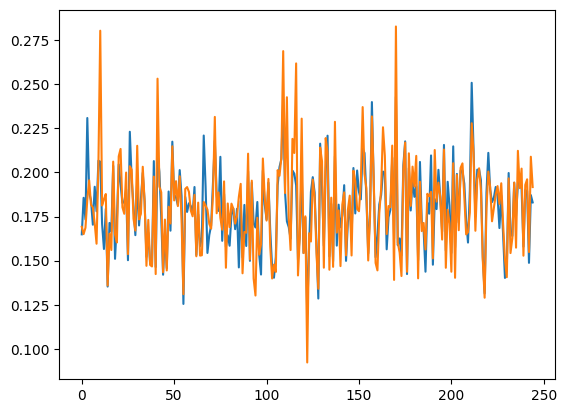

In [247]:
plt.plot(predict_test)
plt.plot(list(test[Y_COL]))

In [248]:
predicts = model.predict(dpredict)

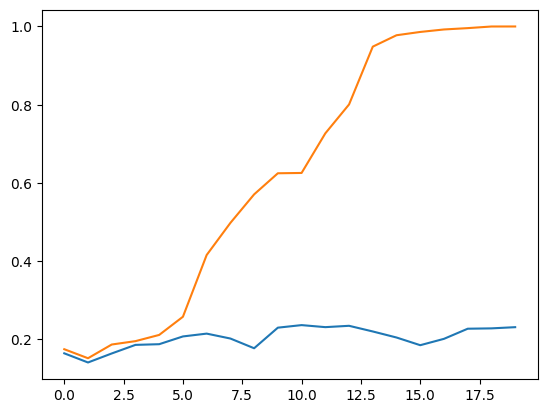

In [249]:
plt.plot(predicts)
plt.plot(list(df_predict[Y_COL]))